In [58]:
from google.colab import drive
# Mount Google Drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [59]:
!pip install shap

In [60]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import model_to_dot
from PIL import Image
from keras.applications import ResNet152V2
from keras.models import Sequential
from keras.layers import GaussianNoise, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten
import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

In [61]:
!unzip "/content/gdrive/MyDrive/Initial_50K.zip" #

Streaming output truncated to the last 5000 lines.
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_840.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8413.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8420.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8423.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8424.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8437.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8438.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8445.png  
  inflating: NSCLC_Radiomics_50k_splitted/validation/Large_cell_carcinoma/Large_cell_carcinoma_8482.pn

In [62]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define your custom data directory
custom_data_dir = '/content/NSCLC_Radiomics_50k_splitted'

# Create an ImageDataGenerator for data loading and augmentation
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load and preprocess your custom dataset
custom_data = data_generator.flow_from_directory(
    f"{custom_data_dir}/test",
    batch_size=64,

)

# Retrieve the input images and labels
X, y = custom_data.next()

# Now you can use the 'model' and 'X' for SHAP analysis or other tasks.


Found 7680 images belonging to 5 classes.


In [63]:
# Resize the images to 80x80
resized_images = []
for image in X:
    pil_image = Image.fromarray(image.astype('uint8'))
    pil_image = pil_image.resize((80, 80), Image.ANTIALIAS)
    resized_image = np.array(pil_image)
    resized_images.append(resized_image)

# Convert the list of resized images back to a NumPy array
X_resized = np.array(resized_images)

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


In [64]:
# Define class names (modify this according to your dataset)
class_names = ["Adenocarcinoma", "Large_cell_carcinoma", "Normal", "Not_otherwise specified", "Squamous cell carcinoma"]

In [65]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Create a simple CNN model
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(80, 80, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(5, activation='softmax'))

# Display the model summary
cnn.summary()

Model: "sequential_206"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_227 (Conv2D)         (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d_204 (MaxPool  (None, 39, 39, 64)        0         
 ing2D)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 97344)             0         
                                                                 
 dense_33 (Dense)            (None, 256)               24920320  
                                                                 
 dropout_225 (Dropout)       (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                    

In [66]:
from keras.applications import ResNet152V2
#Creating Models (Reducing dimentions and preventing Overfitting)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(80, 80, 3))


for layer in base_model.layers:
    layer.trainable=True
resnet = Sequential()
resnet.add(base_model)
resnet.add(GaussianNoise(0.25))
resnet.add(GlobalAveragePooling2D())
resnet.add(Dense(1024,activation='relu'))
resnet.add(BatchNormalization())
resnet.add(GaussianNoise(0.25))
resnet.add(Dropout(0.25))
resnet.add(Flatten())
resnet.add(Dense(5, activation='softmax'))
resnet.summary()

Model: "sequential_207"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 gaussian_noise_6 (Gaussian  (None, 3, 3, 2048)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_37 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_28 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                    

In [67]:
from keras.src.applications import VGG19

# Create the base VGG model with pre-trained weights
base_model_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Make the layers in the base model trainable
for layer in base_model_vgg.layers:
    layer.trainable = True

# Create the VGG model
vgg = Sequential()
vgg.add(base_model_vgg)
vgg.add(GaussianNoise(0.25))
vgg.add(GlobalAveragePooling2D())
vgg.add(Dense(1024, activation='relu'))
vgg.add(BatchNormalization())
vgg.add(GaussianNoise(0.25))
vgg.add(Dropout(0.25))
vgg.add(Flatten())
vgg.add(Dense(5, activation='softmax'))
vgg.summary()

Model: "sequential_208"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 gaussian_noise_8 (Gaussian  (None, 2, 2, 512)         0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_39 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_29 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                    

In [68]:
#Creating Models (Reducing dimentions and preventing Overfitting)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(80, 80, 3))


for layer in base_model.layers:
    layer.trainable=True
xception = Sequential()
xception.add(base_model)
xception.add(GaussianNoise(0.25))
xception.add(GlobalAveragePooling2D())
xception.add(Dense(1024,activation='relu'))
xception.add(BatchNormalization())
xception.add(GaussianNoise(0.25))
xception.add(Dropout(0.25))
xception.add(Flatten())
xception.add(Dense(5, activation='softmax'))
xception.summary()

Model: "sequential_209"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 gaussian_noise_10 (Gaussia  (None, 3, 3, 2048)        0         
 nNoise)                                                         
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_41 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_34 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                    

In [69]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return cnn(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

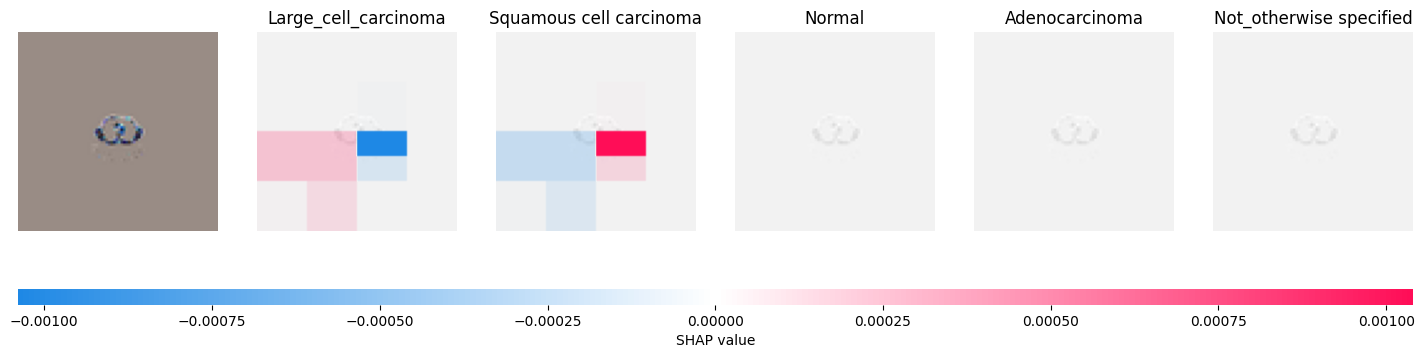

In [70]:
# output with shap values
shap.image_plot(shap_values)

In [71]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return resnet(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:18, 18.11s/it]               


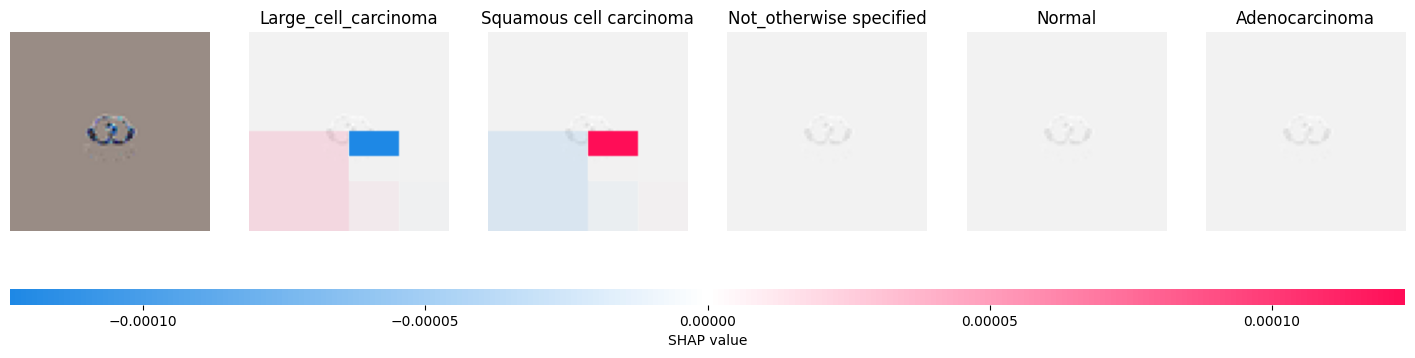

In [72]:
# output with shap values
shap.image_plot(shap_values)

In [73]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return vgg(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.18s/it]               


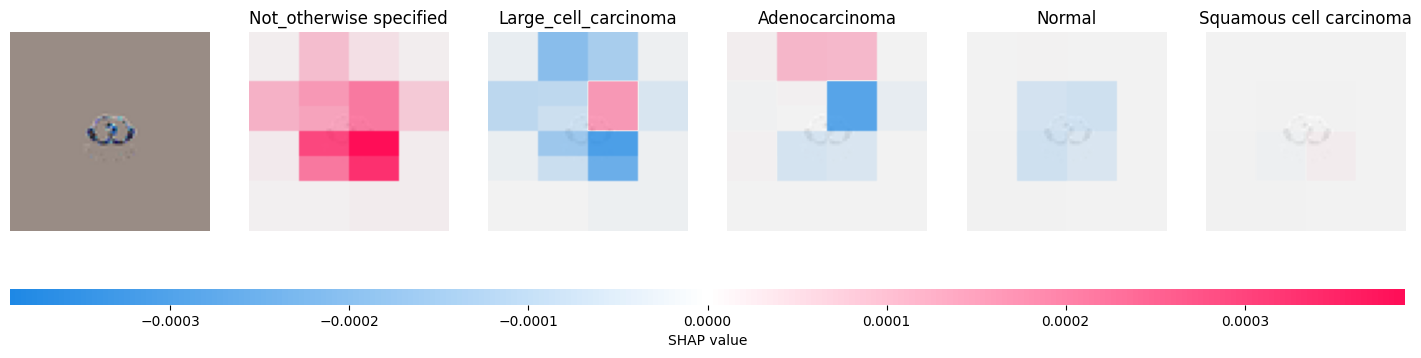

In [74]:
# output with shap values
shap.image_plot(shap_values)

In [75]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return xception(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

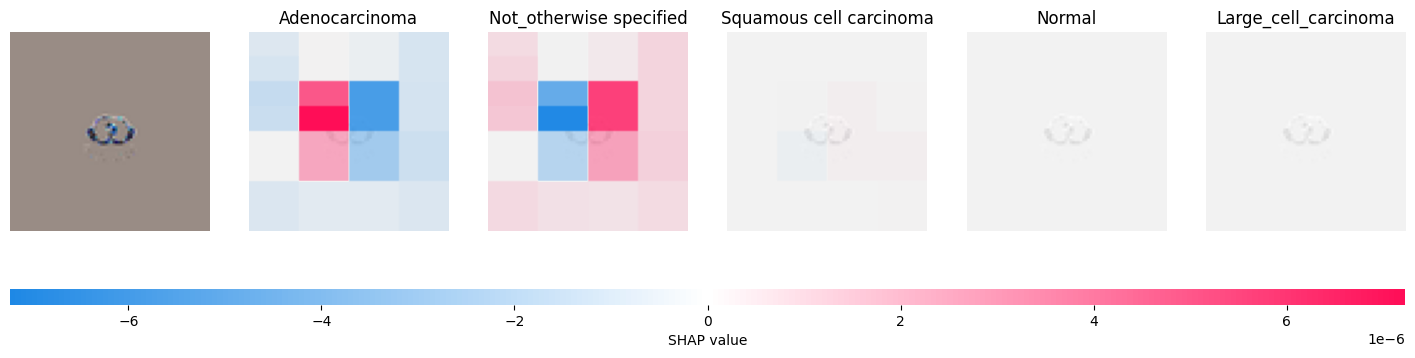

In [76]:
# output with shap values
shap.image_plot(shap_values)

In [77]:
patch_size = (1, 1)
dropout_rate = 0.05
num_heads = 4
embed_dim = 128  # Higher embedding dimension
num_mlp = 64  # Larger MLP layer
qkv_bias = True  # Keep the same
window_size = 2  # Larger attention window
shift_size = 1  # Larger shift size
image_dimension = 80  # Initial image size
input_shape = (80, 80, 3)
num_classes = 5

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 0.001
batch_size = 64
num_epochs = 100  # More epochs
weight_decay = 0.0001
label_smoothing = 0.1

In [78]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    new_height = patch_num_y * window_size
    new_width = patch_num_x * window_size
    x = x[:, :new_height, :new_width, :]  # Trim the input tensor to match the new shape
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [79]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [80]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=2,
        shift_size=1,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [81]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape

        if height % 2 != 0 or width % 2 != 0:
            raise ValueError("Input dimensions must be divisible by 2 for patch merging")

        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [82]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [83]:
swin = keras.Model(input, output)
swin.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 random_crop_1 (RandomCrop)  (None, 80, 80, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 80, 80, 3)         0         
                                                                 
 patch_extract_1 (PatchExtr  (None, 6400, 3)           0         
 act)                                                            
                                                                 
 patch_embedding_1 (PatchEm  (None, 6400, 128)         819712    
 bedding)                                                        
                                                                 
 swin_transformer_2 (SwinTr  (None, 6400, 128)         8318

In [84]:
num_classes = 5
num_positions = 144  # Example for 18x18 image patches
input_shape = (80, 80, 3)
learning_rate = 0.001
weight_decay = 0.0001  # Increase weight decay if overfitting occurs
batch_size = 64
num_epochs = 100
image_size = 80
patch_size = 12
# Increase model complexity
transformer_layers = 4  # Increase the number of Transformer layers
projection_dim = 256    # Increase projection dimension
num_heads = 4
num_patches = (image_size // patch_size) ** 2
transformer_units = [projection_dim , projection_dim]
mlp_head_units = [256, 128, 64]  # Increase MLP size
          # Increase the number of attention heads

In [85]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [86]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [87]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [88]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dropout(0.1)(x3)  # Adjust dropout rate
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # MLP head
    mlp = layers.Dense(256, activation="relu")(representation)  # You can modify the size of the MLP
    mlp = layers.Dropout(0.5)(mlp)
    mlp = layers.Dense(128, activation="relu")(mlp)  # Add more dense layers as needed

    # Classify outputs.
    logits = layers.Dense(num_classes, activation="softmax")(mlp)  # Output layer for classification

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [89]:
vit = create_vit_classifier()
vit.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 patches_2 (Patches)         (None, None, 432)            0         ['input_13[0][0]']            
                                                                                                  
 patch_encoder_2 (PatchEnco  (None, 36, 256)              120064    ['patches_2[0][0]']           
 der)                                                                                             
                                                                                                  
 layer_normalization_227 (L  (None, 36, 256)              512       ['patch_encoder_2[0][0]'

In [90]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 80
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.
batch_size = 64
auto = tf.data.AUTOTUNE
num_classes = 5
learning_rate = 0.002
label_smoothing_factor = 0.1
epochs = 100

In [91]:

from keras.applications import imagenet_utils

def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


# Reference:
# https://keras.io/examples/vision/image_classification_with_vision_transformer/


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with a single 3x3 convolution.
    local_features = layers.Conv2D(projection_dim, kernel_size=3, strides=strides, padding='same')(x)

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Conv2D(x.shape[-1], kernel_size=1, strides=strides, padding='same')(local_features)

    # Combine the folded feature map with the input features.
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    return local_global_features

In [92]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


mobilevit = create_mobilevit()
mobilevit.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 80, 80, 3)            0         ['input_14[0][0]']            
                                                                                                  
 conv2d_232 (Conv2D)         (None, 40, 40, 16)           448       ['rescaling_1[0][0]']         
                                                                                                  
 conv2d_233 (Conv2D)         (None, 40, 40, 32)           512       ['conv2d_232[0][0]']          
                                                                                            

In [93]:
positional_emb = False
conv_layers = 1
projection_dim = 64

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 80

In [94]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [95]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [96]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [97]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_layers=200,  # Increase the number of transformer layers
    hidden_dim=16384,        # Increase the hidden dimension
    stochastic_depth_rate=0.1,
    num_classes=num_classes,
):
    inputs = layers.Input(input_shape)



    # Multi-Head Self-Attention Block
    for i in range(transformer_layers):

        # Encode patches.
        cct_tokenizer = CCTTokenizer()
        encoded_patches = cct_tokenizer(inputs)

        # Calculate Stochastic Depth probabilities.
        dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

        x = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Skip connection
        attention_output = layers.Dropout(rate=dpr[i])(x)
        encoded_patches = layers.Add()([attention_output, encoded_patches])

    # Sequence Pooling
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Feedforward layers with increased hidden dimension
    x = layers.Dense(hidden_dim, activation="relu")(weighted_representation)
    x = layers.Dropout(0.5)(x)

    # Classification Layer
    logits = layers.Dense(num_classes, activation="softmax")(x)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [98]:
cct = create_cct_model()

cct.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 cct_tokenizer_399 (CCTToke  (None, 1600, 64)             1728      ['input_15[0][0]']            
 nizer)                                                                                           
                                                                                                  
 layer_normalization_435 (L  (None, 1600, 64)             128       ['cct_tokenizer_399[0][0]']   
 ayerNormalization)                                                                               
                                                                                            

In [99]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return swin(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

  0%|          | 0/98 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.06s/it]               


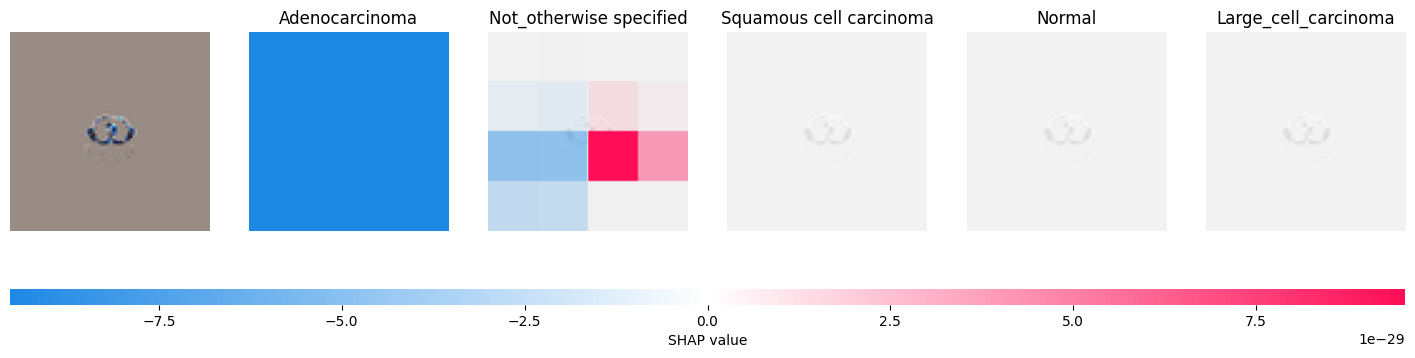

In [100]:
# output with shap values
shap.image_plot(shap_values)

In [101]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return vit(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

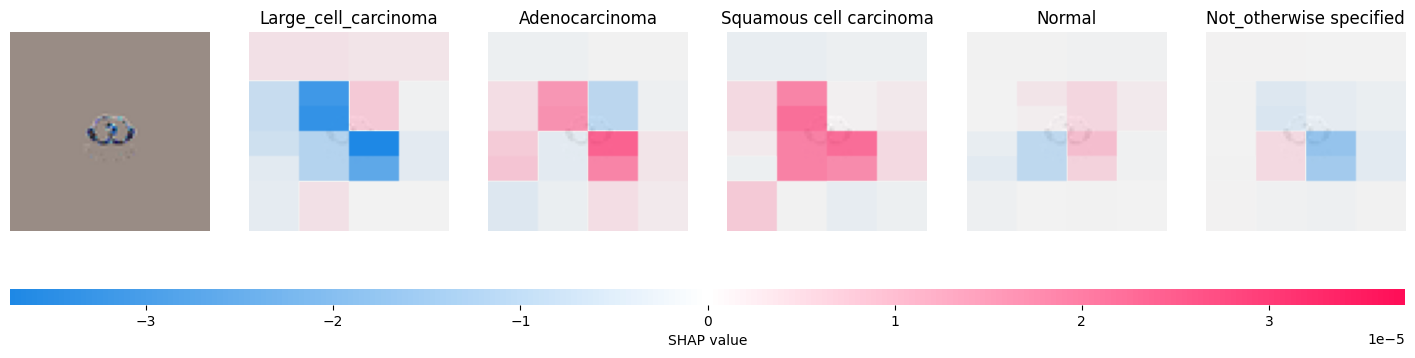

In [102]:
# output with shap values
shap.image_plot(shap_values)

In [103]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return mobilevit(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

  0%|          | 0/98 [00:00<?, ?it/s]

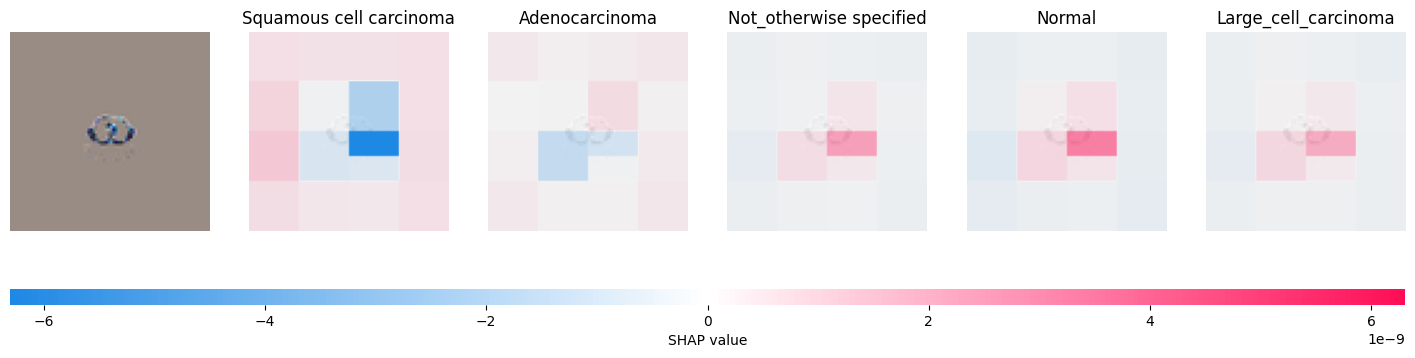

In [104]:
# output with shap values
shap.image_plot(shap_values)

In [105]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return cct(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X_resized[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_resized[1:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)

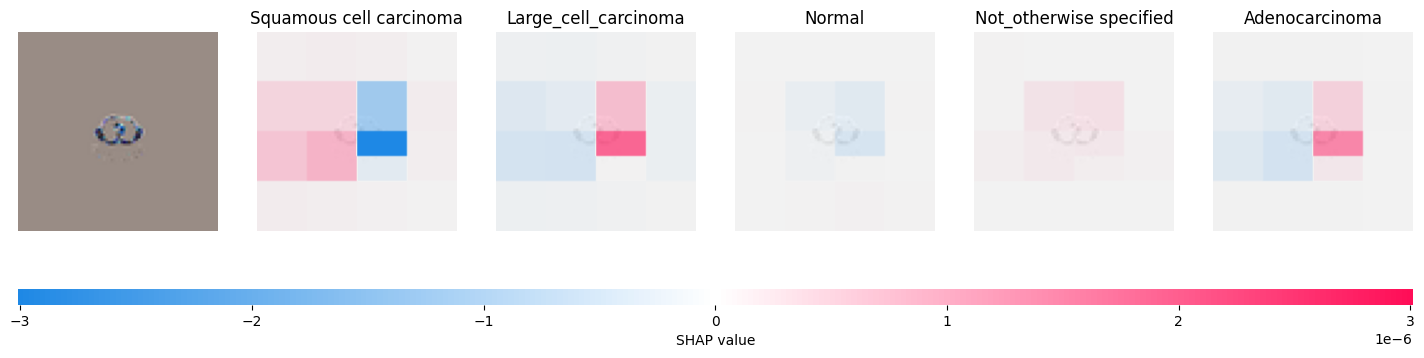

In [106]:
# output with shap values
shap.image_plot(shap_values)